# Experiment 1: All metrics / Default parameters / TSB

## Setup

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [10]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_tsb')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [11]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 7


In [12]:
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#99cae4',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'RF': '#a6d2c3',                    # Useless competitors
    'AFFILIATION': '#95bdaf',        # Useless competitors
    'Range-AUC (L: 128)': '#84a89c',       # Useless competitors
}

In [13]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()

    anom_time_col = [x for x in curr_df.columns if 'oordinates' in x.lower()]
    if len(anom_time_col) > 0:
        curr_df = curr_df.rename({anom_time_col[0]: 'Anomaly coordinates time'}, axis=1)
    
    df = pd.concat([df, curr_df], ignore_index=True)
    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████| 7/7 [00:00<00:00, 90.24it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
8000,OPPORTUNITY/S1-ADL3.test.csv@76.out,32499,2,647.0,NaN,RF,0.276146,0.140720,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4163,OPPORTUNITY/S1-ADL5.test.csv@67.out,30047,2,609.0,NaN,AFFILIATION,0.480817,0.008743,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3083,YAHOO/Yahoo_A2synthetic_80_data.out,1420,3,3.0,128.0,VUS (L: 128),0.080514,0.363070,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

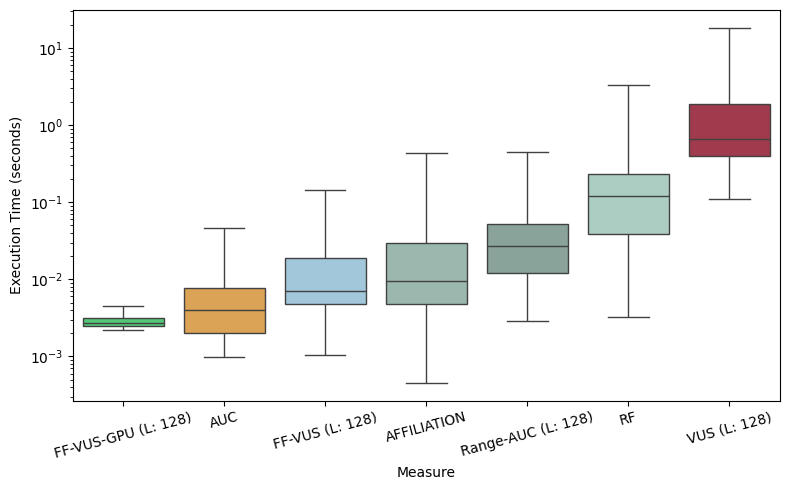

In [14]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    # saturation=1,
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

<Figure size 400x400 with 0 Axes>

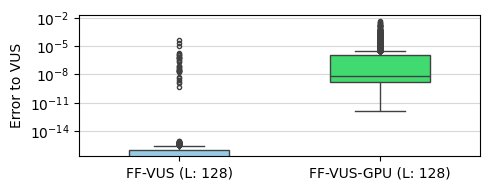

In [19]:
# What is the error between the difference metrics
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')
plt.figure(figsize=(4, 4))

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()

# sns.boxplot(dif_df, showfliers=True, palette=color_palette, saturation=1)
plt.figure(figsize=(5, 2))
sns.boxplot(dif_df, showfliers=True, fill=True, flierprops={"marker": "."}, width=.5, palette=color_palette, saturation=1)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('')
plt.ylabel('Error to VUS')
plt.yscale('log')
# plt.yticks([10**-x for x in range(0, 16)])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
plt.savefig(os.path.join(save_fig_path, 'error_to_vuspr.svg'))
plt.show()

In [39]:
dif_df.sort_values(by='FF-VUS (L: 128)', ascending=False).head(2)

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
YAHOO/YahooA4Benchmark-TS99_data.out,0.000046,0.000226
YAHOO/YahooA3Benchmark-TS75_data.out,0.000020,0.000047


In [51]:
prob_ts = list(dif_df.sort_values(by='FF-VUS (L: 128)', ascending=False).head(2).index)
print(df[np.logical_and(df['Time series'].isin(prob_ts), df['Metric'] == 'FF-VUS (L: 128)')])

                                Time series  Length  Number of anomalies  \
10434  YAHOO/YahooA3Benchmark-TS75_data.out    1679                   14   
10524  YAHOO/YahooA4Benchmark-TS99_data.out    1679                   15   

       Anomalies average length  Slope size           Metric  Metric value  \
10434                  1.000000       128.0  FF-VUS (L: 128)      0.894256   
10524                  1.066667       128.0  FF-VUS (L: 128)      0.616243   

       Metric time  Existence  Step  ... Anomaly coordinates time  \
10434     0.007493  optimized   1.0  ...                 0.000079   
10524     0.007300  optimized   1.0  ...                 0.000080   

      Safe mask time Thresholds time  Score mask time  Position time  \
10434       0.000164        0.000085         0.000241       0.000353   
10524       0.000161        0.000083         0.000187       0.000378   

       Slopes time  Existence time  Confusion matrix time  \
10434     0.001759        0.002959               0

In [29]:
dif_df.sort_values(by='FF-VUS-GPU (L: 128)', ascending=False).head(20)

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128)
Time series,,
MITDB/213.test.csv@2.out,1.110223e-16,0.004074
SVDB/891.test.csv@2.out,4.350244e-09,0.003538
ECG/MBA_ECG14046_data_4.out,1.665335e-16,0.002879
SVDB/879.test.csv@1.out,1.665335e-16,0.002824
SVDB/859.test.csv@1.out,4.797474e-09,0.002279
SVDB/859.test.csv@2.out,6.445958e-08,0.001817
SVDB/865.test.csv@2.out,7.960681e-08,0.001592
SVDB/887.test.csv@1.out,1.110223e-16,0.001588
ECG/MBA_ECG14046_data_42.out,2.129440e-08,0.001413


In [9]:
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    dif_df[attr] = dif_df.apply(
        lambda row: df.loc[df['Time series'] == row.name, attr].values[0],
        axis=1
    )

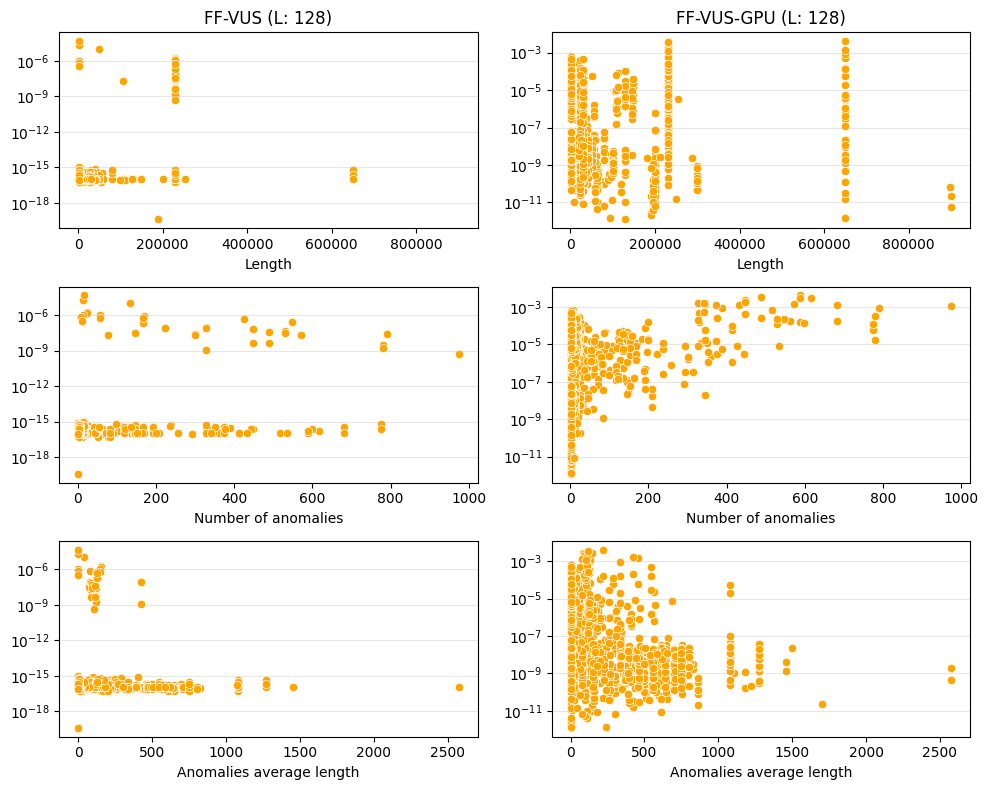

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
curr_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
for i, attr in enumerate(attributes):
    for j, metric in enumerate(curr_metrics):
        sns.scatterplot(dif_df, y=metric, x=attr, ax=ax[i, j], color='orange')
        ax[i, j].set_yscale('log')
        ax[i, j].grid(axis='y', alpha=0.3)
        ax[i, j].set_ylabel('')
        if i == 0:
            ax[i, j].set_title(metric)
        

plt.tight_layout()
plt.show()

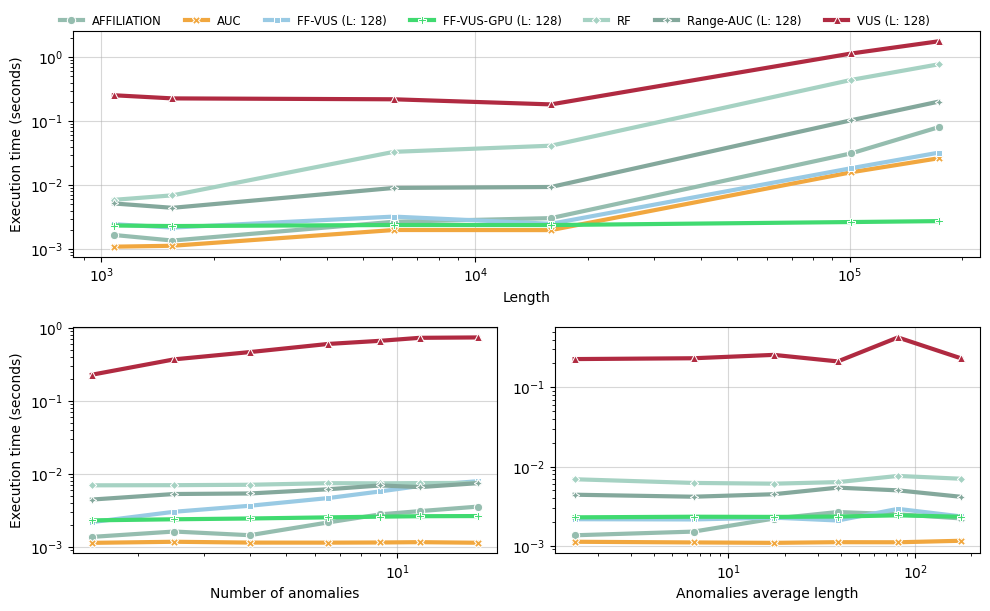

In [11]:
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4)
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    for attr in attributes:
        if attr != attribute:
            mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )

    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=3,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis

handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

## Time analysis

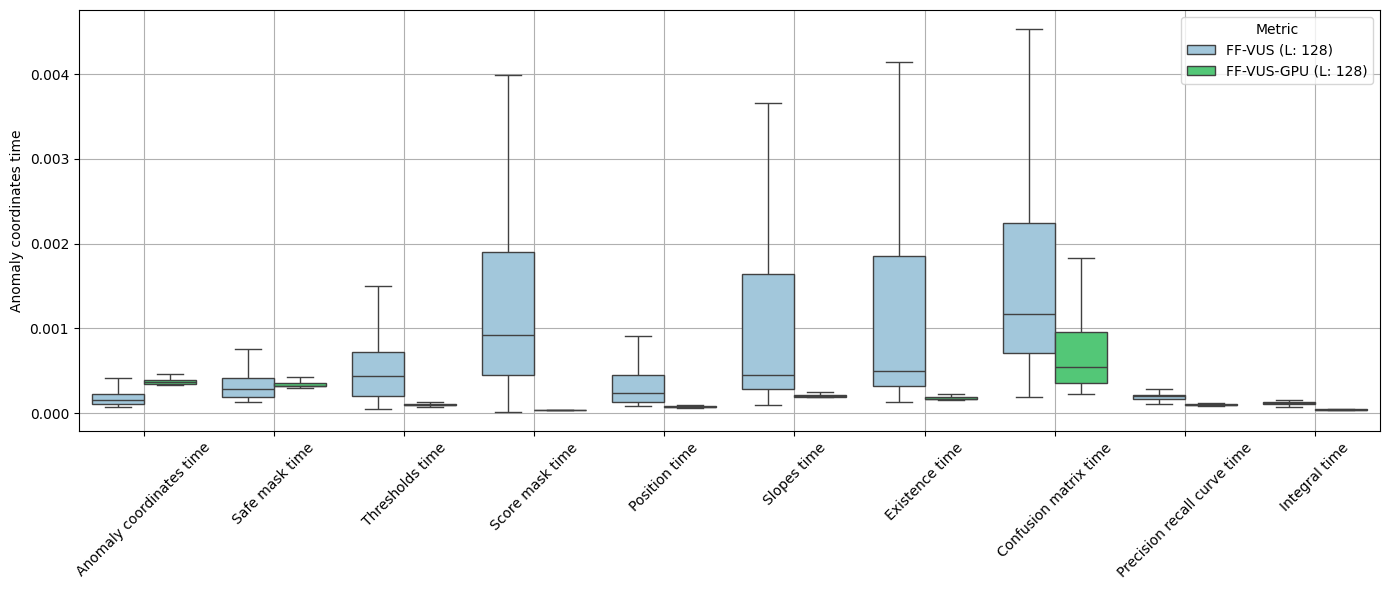

In [84]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    sns.boxplot(curr_df, x=i, y=col, log_scale=False, hue='Metric', legend=(i == 0), palette=color_palette, showfliers=False)
ax.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
ax.tick_params(axis='x', rotation=45)
ax.grid()

plt.tight_layout()
plt.show()

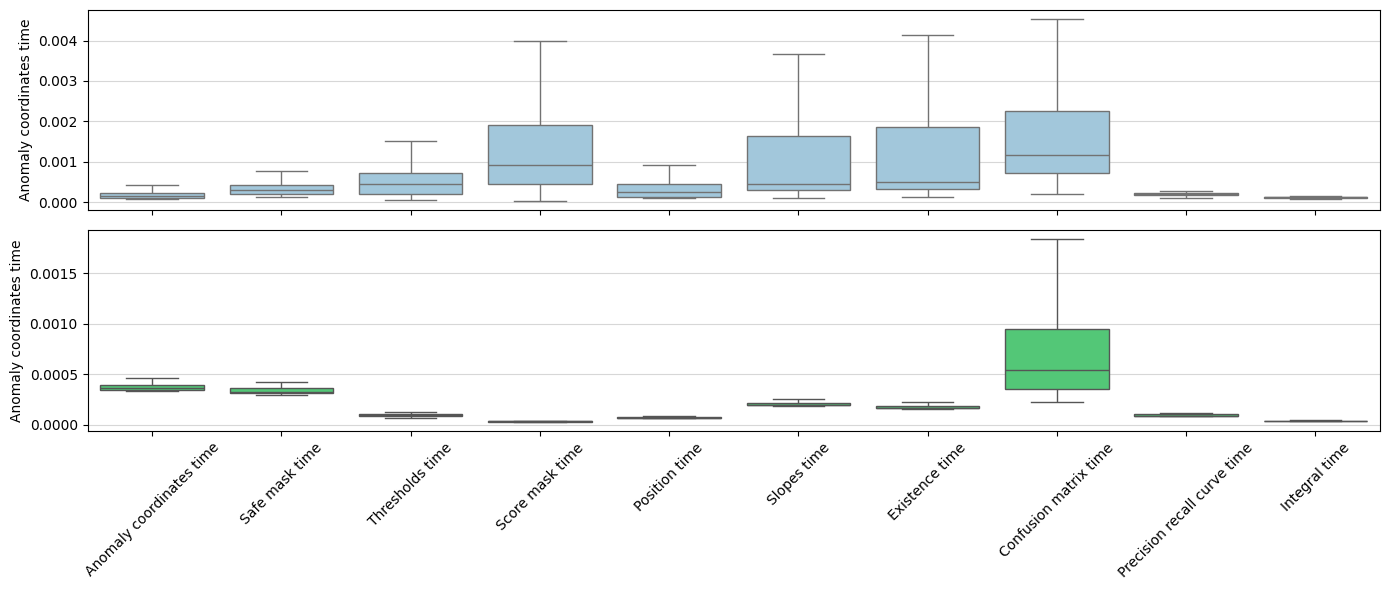

In [100]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharey=False)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(curr_df[curr_df['Metric'] == metrics[j]], ax=axis, x=i, y=col, log_scale=False, legend=(i == 0), color=color_palette[metrics[j]], showfliers=False)
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

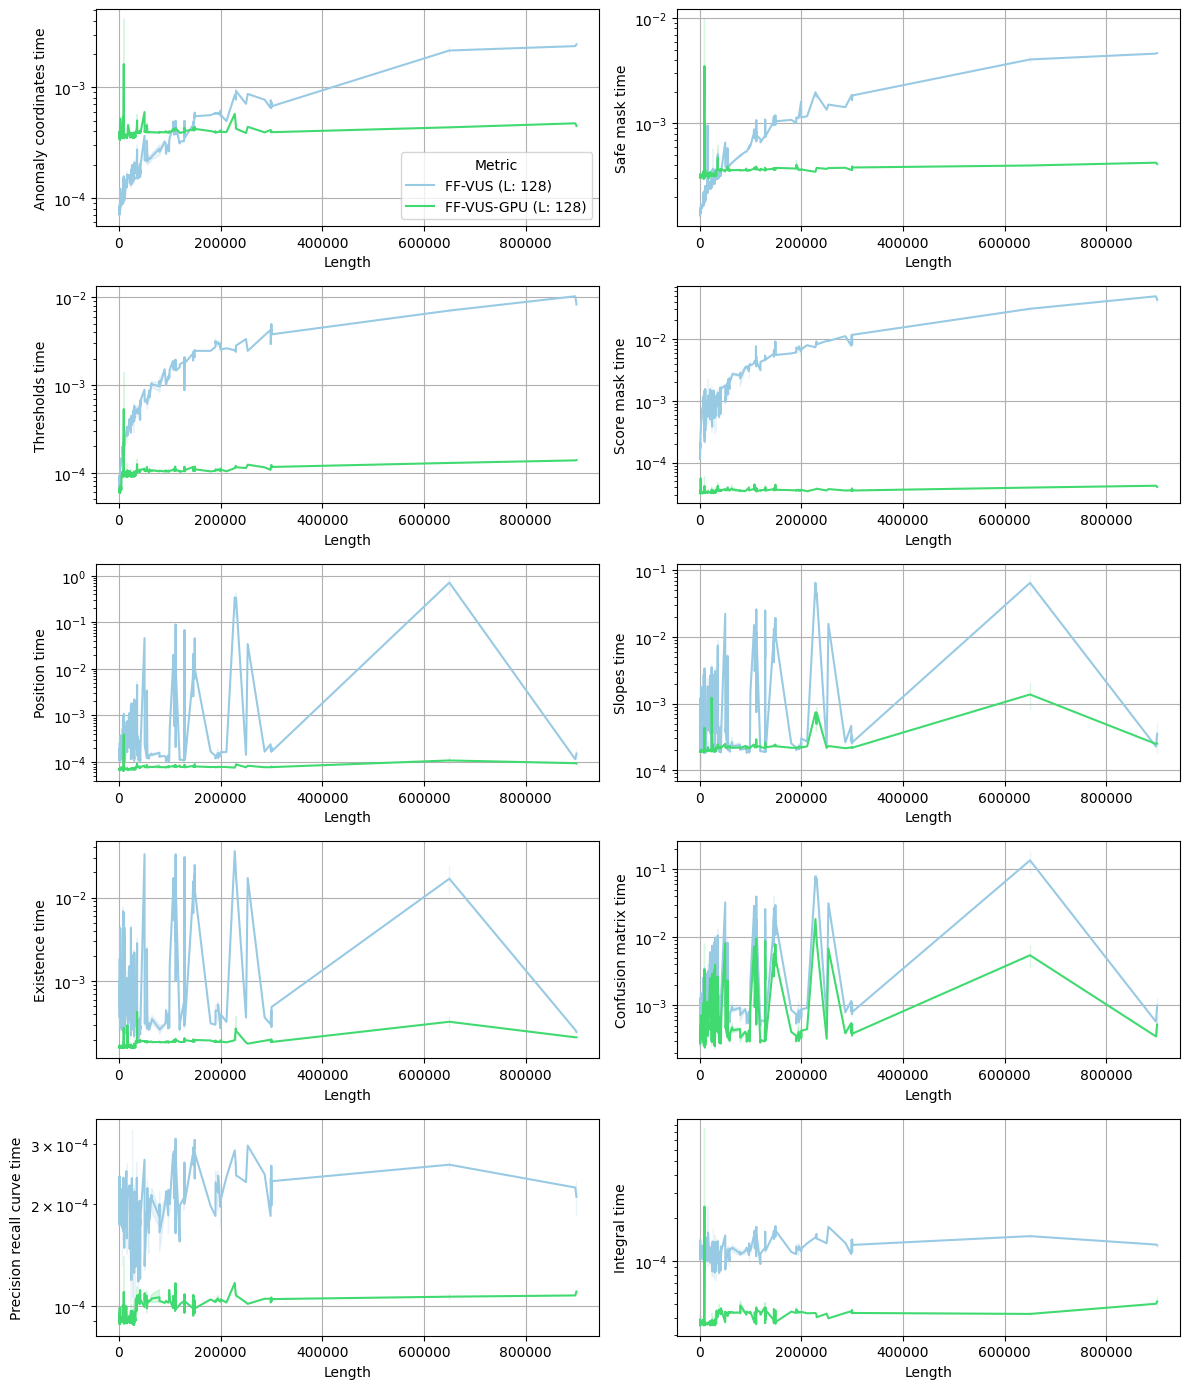

In [81]:
fig, ax = plt.subplots(5, 2, figsize=(12, 14))

for col, axis in zip(time_analysis_cols, ax.flatten()):
    sns.lineplot(
        curr_df, 
        x='Length', 
        y=col, 
        hue='Metric', 
        ax=axis, 
        legend=(col == 'Anomaly coordinates time'), 
        palette=color_palette
    )
    axis.set_yscale('log')
    axis.grid()
plt.tight_layout()
plt.show()